### Deep Kung-Fu with advantage actor-critic

In this notebook you'll build a deep reinforcement learning agent for Atari [Kung-Fu Master](https://gym.openai.com/envs/KungFuMaster-v0/) that uses a recurrent neural net.

![https://upload.wikimedia.org/wikipedia/en/6/66/Kung_fu_master_mame.png](https://upload.wikimedia.org/wikipedia/en/6/66/Kung_fu_master_mame.png)

In [1]:
import sys, os
if 'google.colab' in sys.modules:
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week08_pomdp/atari_util.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week08_pomdp/env_pool.py

        !touch .setup_complete

# If you are running on a server, launch xvfb to record game videos
# Please make sure you have xvfb installed
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

TensorFlow 1.x selected.
Selecting previously unselected package xvfb.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

For starters, let's take a look at the game itself:

* Image resized to 42x42 and converted to grayscale to run faster
* Agent sees last 4 frames of game to account for object velocity

In [3]:
import gym
from atari_util import PreprocessAtari

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(
        env, height=42, width=42,
        crop=lambda img: img[60:-30, 5:],
        dim_order='tensorflow',
        color=False, n_frames=4)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (42, 42, 4)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


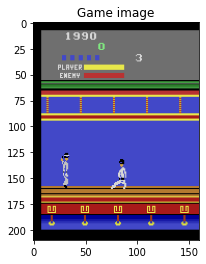

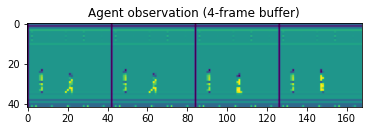

In [4]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0, 2, 1]).reshape([42,-1]))
plt.show()

### Simple agent for fully-observable MDP

Here's a code for an agent that only uses feedforward layers. Please read it carefully: you'll have to extend it later!

In [5]:
import tensorflow as tf
tf.reset_default_graph()

sess = tf.InteractiveSession()

In [6]:
from keras.layers import Conv2D, Dense, Flatten


class FeedforwardAgent:
    def __init__(self, name, obs_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""

        with tf.variable_scope(name, reuse=reuse):
            # Note: number of units/filters is arbitrary, you can and should change it at your will
            self.conv0 = Conv2D(32, (4, 4), strides=(2, 2), activation='relu')
            self.conv1 = Conv2D(64, (3, 3), strides=(2, 2), activation='relu')
            self.conv2 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')

            self.flatten = Flatten()
            self.hid     = Dense(128, activation='relu')
            
            # Actor: pi(a|s)
            self.logits  = Dense(n_actions) 
            
            # Critic: State Values
            self.state_value = Dense(1)

            # prepare a graph for agent step
            _initial_state = self.get_initial_state(1)

            # prepare placeholders: prev_state and obs_t
            self.prev_state_placeholders = [
                tf.placeholder(mem.dtype, [None] + [mem.shape[i] for i in range(1, mem.ndim)])
                for mem in _initial_state
            ]
            self.obs_t = tf.placeholder('float32', [None, ] + list(obs_shape))

            # make a symbolic_step
            self.next_state, self.agent_outputs = self.symbolic_step(self.prev_state_placeholders, self.obs_t)


    def symbolic_step(self, prev_state, obs_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""

        nn = self.conv0(obs_t)
        nn = self.conv1(nn)
        nn = self.conv2(nn)
        nn = self.flatten(nn)
        nn = self.hid(nn)
        logits = self.logits(nn)

        # V(obs_t)
        state_value = self.state_value(nn)

        # feedforward agent has no state
        new_state = []

        return new_state, (logits, state_value)


    def get_initial_state(self, batch_size):
        """Return a list of agent memory states at game start. Each state is a np array of shape [batch_size, ...]"""
        # feedforward agent has no state
        return []


    def step(self, prev_state, obs_t):
        """Same as symbolic state except it operates on numpy arrays"""
        sess = tf.get_default_session()
        feed_dict = {self.obs_t: obs_t}

        for state_ph, state_value in zip(self.prev_state_placeholders, prev_state):
            feed_dict[state_ph] = state_value
        return sess.run([self.next_state, self.agent_outputs], feed_dict)


    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])



Using TensorFlow backend.


In [7]:
n_parallel_games = 5
gamma = 0.99

agent = FeedforwardAgent("agent", obs_shape, n_actions)

sess.run(tf.global_variables_initializer())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
state = [env.reset()]
_, (logits, value) = agent.step(agent.get_initial_state(1), state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[ 0.01017663 -0.01169257 -0.01616725 -0.01037618  0.00128783  0.03425625
   0.00131097 -0.006387   -0.0027057  -0.01552016  0.0005855   0.00346004
  -0.02136897  0.00756453]]
state values:
 [[0.00067303]]


### Let's play!
Let's build a function that measures agent's average reward.

In [9]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        # initial observation and memory
        observation = env.reset()
        prev_memories = agent.get_initial_state(1)

        total_reward = 0
        while True:
            new_memories, readouts = agent.step(
                prev_memories, observation[None, ...])
            action = agent.sample_actions(readouts)

            observation, reward, done, info = env.step(action[0])

            total_reward += reward
            prev_memories = new_memories
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [10]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    rewards = evaluate(agent, env_monitor, n_games=3)

print(rewards)

[1000.0, 1100.0, 800.0]


In [11]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

### Training on parallel games

We introduce a class called EnvPool - it's a tool that handles multiple environments for you. Here's how it works:
![img](https://s7.postimg.cc/4y36s2b2z/env_pool.png)

In [12]:
from env_pool import EnvPool
pool = EnvPool(agent, make_env, n_parallel_games)

In [13]:
# for each of n_parallel_games, take 10 steps
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

In [14]:
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ", rollout_obs.shape)

Actions shape: (5, 10)
Rewards shape: (5, 10)
Mask shape: (5, 10)
Observations shape:  (5, 10, 42, 42, 4)


# Actor-critic objective

Here we define a loss function that uses rollout above to train advantage actor-critic agent.


Our loss consists of three components:

* __The policy "loss"__
 $$ \hat J = {1 \over T} \cdot \sum_t { \log \pi(a_t | s_t) } \cdot A_{const}(s,a) $$
  * This function has no meaning in and of itself, but it was built such that
  * $ \nabla \hat J = {1 \over N} \cdot \sum_t { \nabla \log \pi(a_t | s_t) } \cdot A(s,a) \approx \nabla E_{s, a \sim \pi} R(s,a) $
  * Therefore if we __maximize__ J_hat with gradient descent we will maximize expected reward
  
  
* __The value "loss"__
  $$ L_{td} = {1 \over T} \cdot \sum_t { [r + \gamma \cdot V_{const}(s_{t+1}) - V(s_t)] ^ 2 }$$
  * Ye Olde TD_loss from q-learning and alike
  * If we minimize this loss, V(s) will converge to $V_\pi(s) = E_{a \sim \pi(a | s)} R(s,a) $


* __Entropy Regularizer__
  $$ H = - {1 \over T} \sum_t \sum_a {\pi(a|s_t) \cdot \log \pi (a|s_t)}$$
  * If we __maximize__ entropy we discourage agent from predicting zero probability to actions
  prematurely (a.k.a. exploration)
  
  
So we optimize a linear combination of $L_{td} - \hat J -H$


__One more thing:__ since we train on T-step rollouts, we can use N-step formula for advantage for free:
  * At the last step, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot V(s_{t+1}) - V(s) $
  * One step earlier, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot r(s_{t+1}, a_{t+1}) + \gamma ^ 2 \cdot V(s_{t+2}) - V(s) $
  * Et cetera, et cetera. This way agent starts training much faster since it's estimate of A(s,a) depends less on his (imperfect) value function and more on actual rewards. There's also a [nice generalization](https://arxiv.org/abs/1506.02438) of this.


__Note:__ it's also a good idea to scale rollout_len up to learn longer sequences. You may wish set it to >=20 or to start at 10 and then scale up as time passes.

In [15]:
# [batch, time, h, w, c]
observations_ph = tf.placeholder('float32', [None, None,] + list(obs_shape))
actions_ph      = tf.placeholder('int32',   (None, None,))
mask_ph         = tf.placeholder('float32', (None, None,))
rewards_ph      = tf.placeholder('float32', (None, None,))
cumulative_rewards_ph = tf.placeholder('float32', (None, None,))

initial_memory_ph = agent.prev_state_placeholders

# get new_state, (actor->logits, critic->state_value)
_, dummy_outputs = agent.symbolic_step(initial_memory_ph,
                                       observations_ph[:, 0])
print(dummy_outputs)

_, outputs_seq = tf.scan(
    lambda stack, obs_t: agent.symbolic_step(stack[0], obs_t),
    initializer = (initial_memory_ph, dummy_outputs),
    elems = tf.transpose(observations_ph, [1, 0, 2, 3, 4])
    # elem.shape = [time, batch, h, w, c]
)
print(outputs_seq)

# from [time, batch] back to [batch, time]
outputs_seq = [tf.transpose(
    tensor, [1, 0] + list(range(2, tensor.shape.ndims))) for tensor in outputs_seq]

print(outputs_seq)

(<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 14) dtype=float32>, <tf.Tensor 'dense_3/BiasAdd:0' shape=(?, 1) dtype=float32>)
(<tf.Tensor 'scan/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 14) dtype=float32>, <tf.Tensor 'scan/TensorArrayStack_1/TensorArrayGatherV3:0' shape=(?, ?, 1) dtype=float32>)
[<tf.Tensor 'transpose_1:0' shape=(?, ?, 14) dtype=float32>, <tf.Tensor 'transpose_2:0' shape=(?, ?, 1) dtype=float32>]


In [16]:
# actor-critic losses
# actor  -> logits, with shape: [batch, time, n_actions]
# critic -> states, with shape: [batch, time, 1]
logits_seq, state_values_seq = outputs_seq

logprobs_seq = tf.nn.log_softmax(logits_seq)
logp_actions = tf.reduce_sum(logprobs_seq * tf.one_hot(actions_ph, n_actions),
                             axis=-1)[:, :-1]

current_rewards = rewards_ph[:, :-1] / 100.
current_state_values = state_values_seq[:, :-1, 0]

next_state_values = state_values_seq[:, 1:, 0] * mask_ph[:, :-1]


# policy gradient
# compute 1-step advantage using current_rewards, current_state_values and next_state_values
advantage = cumulative_rewards_ph[:, :-1] - current_state_values
assert advantage.shape.ndims == 2

# compute policy entropy given logits_seq. Mind the sign!
policy  = tf.nn.softmax(logits_seq, axis=-1)
entropy = - tf.reduce_sum(policy * logprobs_seq, axis=-1)
assert entropy.shape.ndims == 2

actor_loss = - tf.reduce_mean(logp_actions * tf.stop_gradient(advantage))
actor_loss -= 0.01 * tf.reduce_mean(entropy)

# Prepare Temporal Difference error (States)
target_state_values = current_rewards + gamma * next_state_values
critic_loss = tf.reduce_mean(
    (current_state_values - tf.stop_gradient(target_state_values))**2)


train_step = tf.train.AdamOptimizer(1e-4).minimize(actor_loss + critic_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
sess.run(tf.global_variables_initializer())

# Train 

just run train step and see if agent learns any better

In [18]:
def acc_rewards(rewards,    # rewards at each step [batch, time]
                gamma=0.99  # discount for reward
                ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    curr_rewards = rewards / 100.
    b_size, time = rewards.shape
    
    acc_reward = np.zeros((b_size, time), dtype='float32')
    acc_reward[:,time-1] = curr_rewards[:,time-1]

    for i in reversed(np.arange(time-1)):
        acc_reward[:,i] = curr_rewards[:,i] + gamma * acc_reward[:,i+1]
        
    return acc_reward

In [19]:
def sample_batch(rollout_length=10):
    prev_mem = pool.prev_memory_states
    
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(rollout_length)
    rollout_cumulative_rewards = acc_rewards(rollout_rewards)
        
    feed_dict = {
        observations_ph: rollout_obs,
        actions_ph: rollout_actions,
        
        rewards_ph: rollout_rewards,
        cumulative_rewards_ph: rollout_cumulative_rewards,
        
        mask_ph: rollout_mask
    }

    for placeholder, value in zip(initial_memory_ph, prev_mem):
        feed_dict[placeholder] = value

    return feed_dict

In [20]:
from IPython.display import clear_output

from tqdm import trange
from pandas import DataFrame

moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

rewards_history = []

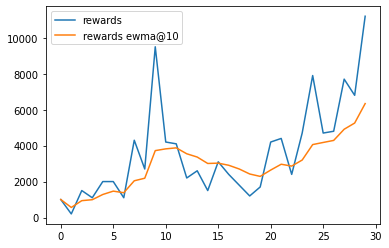

Your agent has just passed the minimum homework threshold


In [21]:
for i in range(5000):
    sess.run(train_step, sample_batch())

    if i % 100 == 0:
        rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))
        clear_output(True)
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history),
                                span=10), label='rewards ewma@10')
        plt.legend()
        plt.show()
        if rewards_history[-1] >= 10000:
            print("Your agent has just passed the minimum homework threshold")
            break

### "Final" evaluation

In [22]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=20)

print("Final mean reward", np.mean(final_rewards))

Final mean reward 6745.0


In [23]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices